In [1]:
import pandas as pd
import numpy as np
import pydotplus 
import io
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import misc
%matplotlib inline

In [2]:
url = 'https://raw.githubusercontent.com/shughestr/PIMS_2020_Real_Estate_data/master/sample_clean.csv'
df = pd.read_csv(url, error_bad_lines=False)
df=df.dropna()
# in this step, we removed 2 columns 
for col in df.columns:
    if len(df[col].unique())==1:
        df.drop(col,inplace=True,axis=1)
  

In [48]:
type(df)

pandas.core.frame.DataFrame

In [49]:
df.describe()


,ASSESSED_VALUE,LATITUDE,LONGITUDE,ROLL_NUMBER,Year,pct_change,YEAR_OF_CONSTRUCTION,saf1,saf2,saf3,...,inc2,inc3,inc4,own1,own2,own3,own4,lab1,lab2,lab3
count,1.529900e+04,15299.000000,15299.000000,1.529900e+04,15299.000000,15299.000000,15299.000000,15299.000000,15299.000000,15299.000000,...,15299.000000,15299.000000,15299.000000,15299.000000,15299.000000,15299.000000,15299.000000,15299.000000,15299.000000,15299.000000
mean,4.523004e+05,51.044774,-114.079116,1.620781e+08,2018.476306,-0.017837,1982.097719,106.809399,130.776325,82.116086,...,29247.783842,43722.751552,97130.447349,63.306497,16.469586,9.336610,0.712607,72.089679,9.703098,0.255145
std,3.584834e+05,0.074284,0.081449,1.699462e+08,1.117147,0.061942,18.441249,96.890371,122.342968,50.463169,...,11550.226079,6801.840770,20128.584981,9.575663,3.173984,4.635557,0.143195,3.760563,1.033558,0.037996
min,0.000000e+00,50.878051,-114.268044,4.017208e+06,2017.000000,-1.000000,1905.000000,7.000000,6.000000,5.000000,...,5805.000000,30445.000000,66906.000000,46.500000,11.000000,0.000000,0.279715,66.100000,7.300000,0.155717
25%,3.077500e+05,50.990644,-114.136302,5.720901e+07,2017.000000,-0.048556,1972.000000,51.000000,60.000000,41.000000,...,20825.000000,40936.000000,78538.000000,55.500000,14.400000,6.900000,0.614027,68.700000,9.000000,0.231198
50%,4.060000e+05,51.053371,-114.082223,1.120925e+08,2018.000000,-0.021841,1981.000000,71.000000,99.000000,75.000000,...,28850.000000,43467.000000,93829.000000,63.300000,15.600000,8.800000,0.749317,71.400000,10.000000,0.263215
75%,5.285000e+05,51.106223,-114.018736,2.001100e+08,2019.000000,0.004292,1998.000000,127.000000,150.000000,115.000000,...,38350.000000,46204.000000,109414.000000,68.200000,18.600000,10.600000,0.830119,74.900000,10.300000,0.284322
max,8.490000e+06,51.175721,-113.923311,7.920388e+08,2020.000000,2.535725,2019.000000,421.000000,780.000000,259.000000,...,50000.000000,59829.000000,147903.000000,91.800000,26.200000,26.500000,0.934105,82.800000,11.300000,0.319590


In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15299 entries, 0 to 15999
Data columns (total 41 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ADDRESS               15299 non-null  object 
 1   ASSESSED_VALUE        15299 non-null  float64
 2   COMM_CODE             15299 non-null  object 
 3   COMM_NAME             15299 non-null  object 
 4   LATITUDE              15299 non-null  float64
 5   LONGITUDE             15299 non-null  float64
 6   ROLL_NUMBER           15299 non-null  int64  
 7   Year                  15299 non-null  int64  
 8   location              15299 non-null  object 
 9   fsa                   15299 non-null  object 
 10  pct_change            15299 non-null  float64
 11  YEAR_OF_CONSTRUCTION  15299 non-null  float64
 12  saf1                  15299 non-null  float64
 13  saf2                  15299 non-null  float64
 14  saf3                  15299 non-null  float64
 15  saf4               

In [51]:
from itertools import product

def check_cardinality(df):

    combinations_lst = list(product(df.columns, df.columns))
    relations = ['one_to_one', 'one_to_many', 'many_to_one']

    output = []
    for col1, col2 in combinations_lst:
        for relation in relations:
            try:
                pd.merge(df[[col1]], df[[col2]], left_on=col1, right_on=col2, validate=relation)
                output.append([col1, col2, relation])
            except:
                continue

    return output



In [52]:
def get_relation(df, col1, col2):        
    first_max = df[[col1, col2]].groupby(col1).count().max()[0]
    second_max = df[[col1, col2]].groupby(col2).count().max()[0]
    if first_max==1:
        if second_max==1:
            return 'one-to-one'
        else:
            return 'one-to-many'
    else:
        if second_max==1:
            return 'many-to-one'
        else:
            return 'many-to-many'

from itertools import product
for col_i, col_j in product(df.columns, df.columns):
    if col_i == col_j:
        continue
    print(col_i, col_j, get_relation(df, col_i, col_j))

ADDRESS ASSESSED_VALUE many-to-many
ADDRESS COMM_CODE many-to-many
ADDRESS COMM_NAME many-to-many
ADDRESS LATITUDE many-to-many
ADDRESS LONGITUDE many-to-many
ADDRESS ROLL_NUMBER many-to-many
ADDRESS Year many-to-many
ADDRESS location many-to-many
ADDRESS fsa many-to-many
ADDRESS pct_change many-to-many
ADDRESS YEAR_OF_CONSTRUCTION many-to-many
ADDRESS saf1 many-to-many
ADDRESS saf2 many-to-many
ADDRESS saf3 many-to-many
ADDRESS saf4 many-to-many
ADDRESS saf5 many-to-many
ADDRESS saf6 many-to-many
ADDRESS saf7 many-to-many
ADDRESS saf8 many-to-many
ADDRESS mr5y many-to-many
ADDRESS Inflation many-to-many
ADDRESS pop1 many-to-many
ADDRESS pop2 many-to-many
ADDRESS pop3 many-to-many
ADDRESS pop4 many-to-many
ADDRESS pop5 many-to-many
ADDRESS pop6 many-to-many
ADDRESS lan1 many-to-many
ADDRESS lan2 many-to-many
ADDRESS inc1 many-to-many
ADDRESS inc2 many-to-many
ADDRESS inc3 many-to-many
ADDRESS inc4 many-to-many
ADDRESS own1 many-to-many
ADDRESS own2 many-to-many
ADDRESS own3 many-to-man

In [68]:
df['y_bin']=pd.cut(df['pct_change'], bins=10)
train, test= train_test_split(df, test_size=0.2)

In [54]:
print("Training size:{}; Test size: {}".format(len(train),len(test)))

Training size:12239; Test size: 3060


In [55]:
train.shape

(12239, 41)

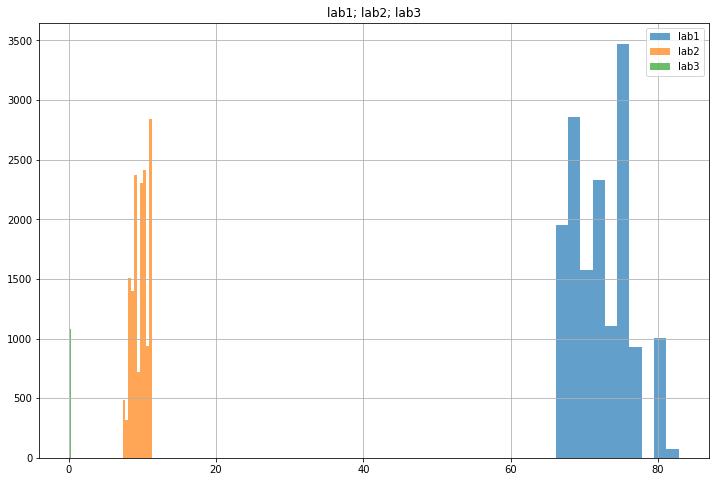

In [56]:
fig=plt.figure(figsize=(12,8))
plt.title("lab1; lab2; lab3")
df['lab1'].hist(alpha=0.7,label='lab1')
df['lab2'].hist(alpha=0.7,label='lab2')
df['lab3'].hist(alpha=0.7,label='lab3')
plt.legend(loc="upper right")

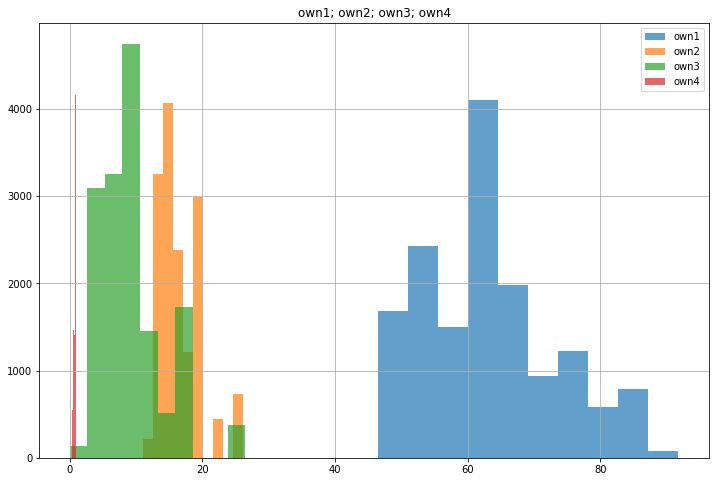

In [57]:
fig=plt.figure(figsize=(12,8))
plt.title("own1; own2; own3; own4")
df['own1'].hist(alpha=0.7,label='own1')
df['own2'].hist(alpha=0.7,label='own2')
df['own3'].hist(alpha=0.7,label='own3')
df['own4'].hist(alpha=0.7,label='own4')
plt.legend(loc="upper right")

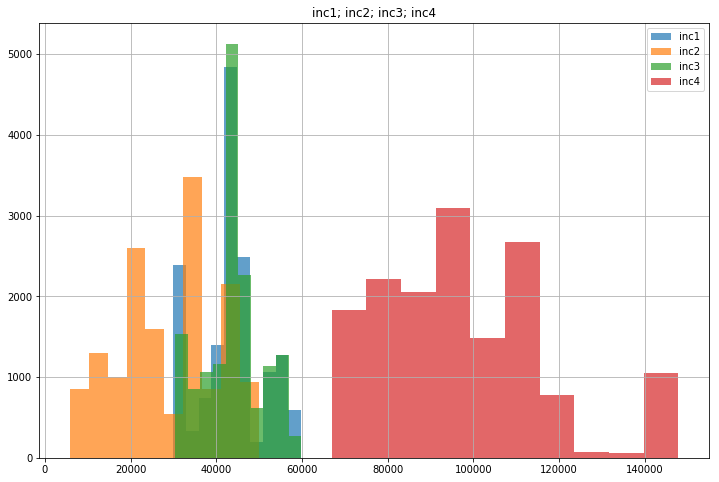

In [58]:
fig=plt.figure(figsize=(12,8))
plt.title("inc1; inc2; inc3; inc4")
df['inc1'].hist(alpha=0.7,label='inc1')
df['inc2'].hist(alpha=0.7,label='inc2')
df['inc3'].hist(alpha=0.7,label='inc3')
df['inc4'].hist(alpha=0.7,label='inc4')
plt.legend(loc="upper right")

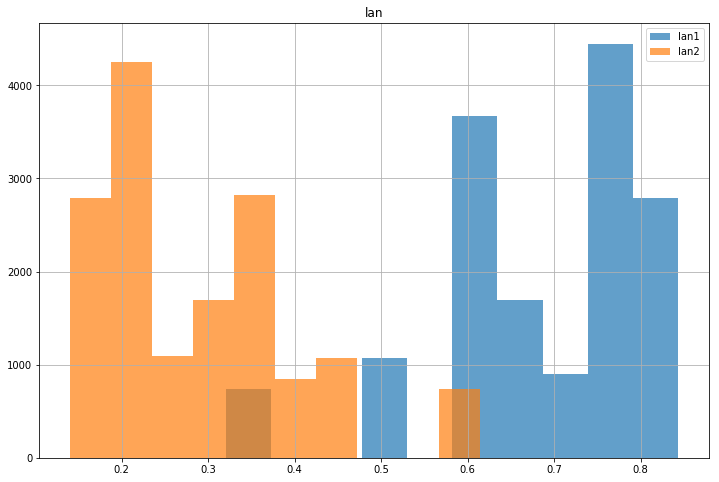

In [59]:
fig=plt.figure(figsize=(12,8))
plt.title("lan")
df['lan1'].hist(alpha=0.7,label='lan1')
df['lan2'].hist(alpha=0.7,label='lan2')
plt.legend(loc="upper right")

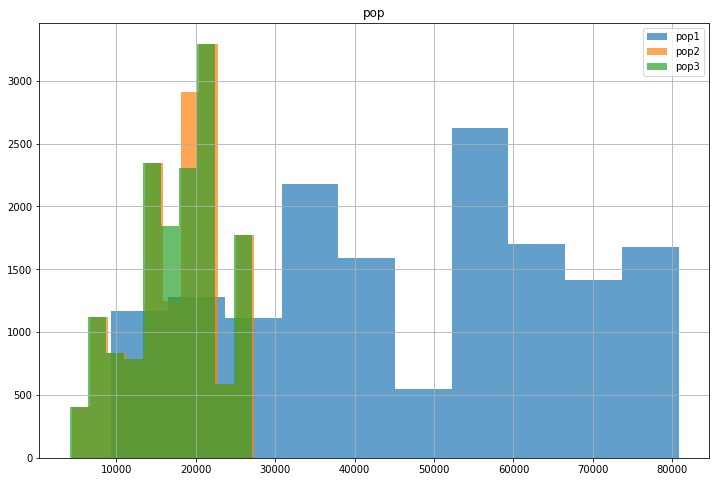

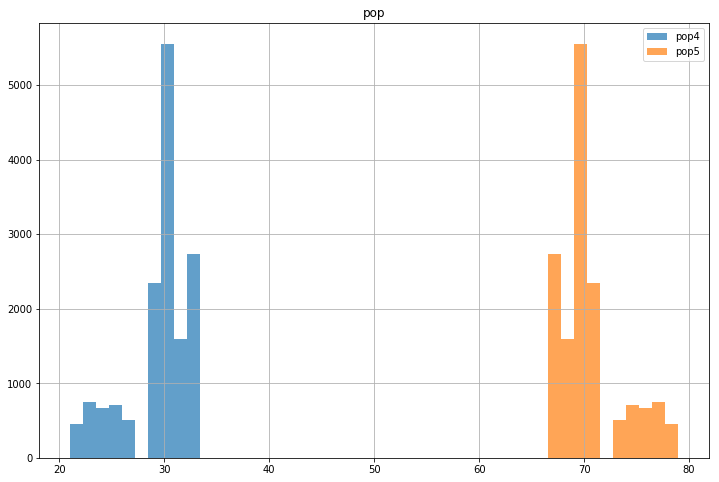

In [60]:
fig=plt.figure(figsize=(12,8))
plt.title("pop")
df['pop1'].hist(alpha=0.7,label='pop1')
df['pop2'].hist(alpha=0.7,label='pop2')
df['pop3'].hist(alpha=0.7,label='pop3')
plt.legend(loc="upper right")

fig=plt.figure(figsize=(12,8))
plt.title("pop")
df['pop4'].hist(alpha=0.7,label='pop4')
df['pop5'].hist(alpha=0.7,label='pop5')
plt.legend(loc="upper right")

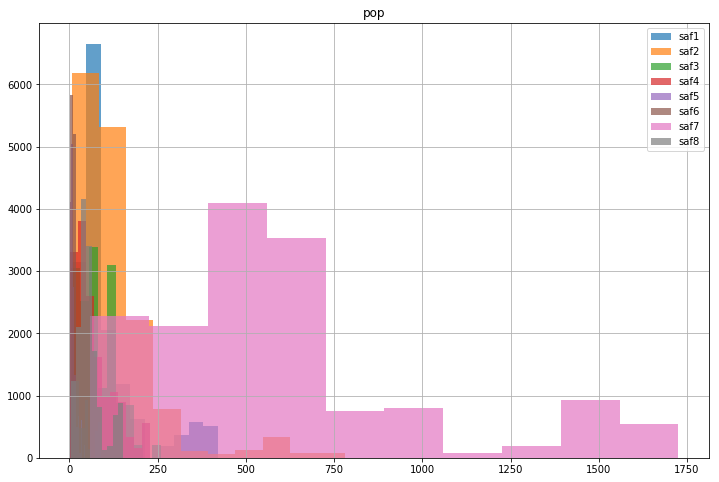

In [61]:
fig=plt.figure(figsize=(12,8))
plt.title("pop")
df['saf1'].hist(alpha=0.7,label='saf1')
df['saf2'].hist(alpha=0.7,label='saf2')
df['saf3'].hist(alpha=0.7,label='saf3')
df['saf4'].hist(alpha=0.7,label='saf4')
df['saf5'].hist(alpha=0.7,label='saf5')
df['saf6'].hist(alpha=0.7,label='saf6')
df['saf7'].hist(alpha=0.7,label='saf7')
df['saf8'].hist(alpha=0.7,label='saf8')

plt.legend(loc="upper right")


In [74]:
c=DecisionTreeClassifier(min_samples_split=1000)

In [6]:
features=["Year","YEAR_OF_CONSTRUCTION","saf1","saf2","saf3","saf4","saf5","saf6","saf7","saf8","mr5y","Inflation","pop1","pop2","pop3","pop4","pop5","pop6","lan1","lan2","inc1","inc2","inc3","inc4","own1","own2","own3","own4","lab1","lab2","lab3"]

In [71]:
X_train=train[features]
pd.cut(train['pct_change'], bins=10).value_counts()

#y_train=np.sign(train["pct_change"])
y_train=train['y_bin']
X_test=test[features]
#y_test=np.sign(test["pct_change"])
y_test=test['y_bin']


In [77]:
dt=c.fit(X_train, y_train)

In [78]:
def show_tree(tree, features, path):
    f=io.StringIO()
    export_graphviz(tree, out_file=f, feature_names=features)
    pydotplus.graph_from_dot_data(f.getvalue()).write_png(path)
    img=misc.imread(path)
    plt.rcParams["figure.figsize"]=(20,20)
    plt.imshow(img)

/Users/DongyingWang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """


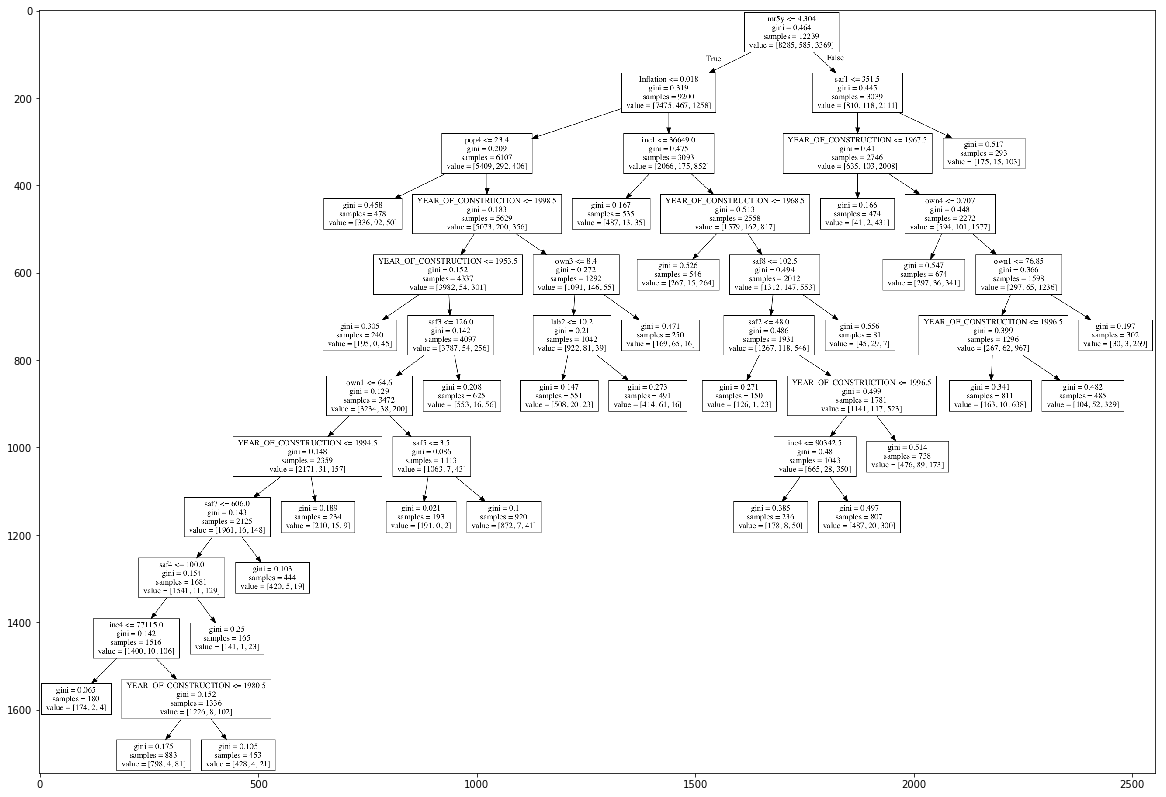

In [79]:
show_tree(dt,features,"dec_tree_02.png")

In [80]:
y_pred=c.predict(X_test)

In [81]:
y_pred

array([ 1., -1., -1., ..., -1.,  1., -1.])

In [82]:
from sklearn.metrics import accuracy_score
score=accuracy_score(y_test,y_pred)*100
print("Accuracy using Decision Tree:", round(score, 1),"%")

Accuracy using Decision Tree: 78.9 %


In [13]:
from sklearn.preprocessing import StandardScaler
#from sklearn.preprocessing import MinMaxScaler
scaler=StandardScaler()
scaler.fit(df[features])
scaled_data=scaler.transform(df[features])
scaled_data

array([[-1.32153984e+00,  9.70805500e-01,  1.79787003e+00, ...,
         2.74460865e-03,  1.90514983e-01,  4.77460551e-01],
       [-4.26373010e-01,  9.70805500e-01,  2.05590205e+00, ...,
         2.74460865e-03,  1.90514983e-01,  4.77460551e-01],
       [ 4.68793819e-01,  9.70805500e-01,  2.33457662e+00, ...,
         2.74460865e-03,  1.90514983e-01,  4.77460551e-01],
       ...,
       [-4.26373010e-01,  1.07926157e+00, -7.30843666e-01, ...,
         2.84815636e+00, -2.22839413e+00, -2.61686218e+00],
       [ 4.68793819e-01,  1.07926157e+00, -5.55381899e-01, ...,
         2.84815636e+00, -2.22839413e+00, -2.61686218e+00],
       [ 1.36396065e+00,  1.07926157e+00, -8.85662872e-01, ...,
         2.84815636e+00, -2.22839413e+00, -2.61686218e+00]])

In [51]:
from sklearn.decomposition import PCA
pca=PCA(n_components=2)
pca.fit(scaled_data)

PCA(n_components=3)

In [52]:
x_pca=pca.transform(scaled_data)

In [53]:
x_pca

array([[ 7.56699359,  0.9070538 ,  1.637242  ],
       [ 8.37546503,  1.67505101,  1.74022674],
       [ 8.08264414,  1.49180291,  1.63683997],
       ...,
       [-3.14241942, -1.85230003,  5.28784997],
       [-3.07919303, -1.70970686,  5.27395494],
       [-3.96369286, -2.35090412,  4.81719953]])

Text(0, 0.5, 'Second principle component')

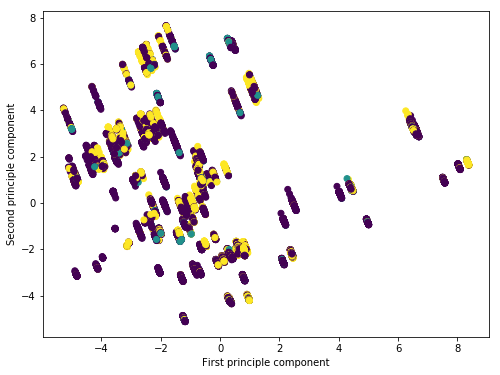

In [17]:
plt.figure(figsize=(8,6))
plt.scatter(x_pca[:,0],x_pca[:,1],c=np.sign(df['pct_change']))
plt.xlabel('First principle component')
plt.ylabel('Second principle component')

In [16]:
#np.sign(df['pct_change']).unique()

array([-1.,  1.,  0.])

Text(0, 0.5, 'cumulative explained variance')

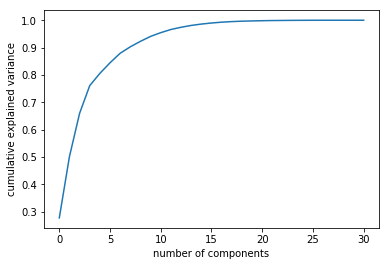

In [69]:
pca = PCA().fit(scaled_data)
ratio=np.cumsum(pca.explained_variance_ratio_)
plt.plot(ratio)
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

In [68]:
ratio

array([0.27691   , 0.50113353, 0.65941345, 0.76082014, 0.80565153,
       0.84439123, 0.87922182, 0.90286136, 0.92288139, 0.94091273,
       0.95458806, 0.9661401 , 0.97426273, 0.98101497, 0.98599346,
       0.98988024, 0.99294462, 0.99503541, 0.9965701 , 0.99751023,
       0.99828585, 0.99889796, 0.99924571, 0.99954476, 0.99979366,
       0.99993452, 0.99998518, 0.9999932 , 0.99999637, 0.99999851,
       1.        ])

In [34]:
cat_feats=list(train.select_dtypes(include='object').columns)
cat_feats_num=['LATITUDE','LONGITUDE','ROLL_NUMBER','Year']
cat_feats=cat_feats+cat_feats_num
num_feats=list(set(train.columns)-set(cat_feats)-set(['ASSESSED_VALUE']))
print('Numerical Features:', len(num_feats))
for feat in num_feats:
    print(feat, end=',')

Numerical Features: 31
saf1,own1,pop1,pop2,inc1,lan2,saf5,saf6,lab3,pct_change,own2,saf4,pop4,inc3,pop5,pop6,lab1,YEAR_OF_CONSTRUCTION,pop3,saf2,own4,saf8,saf7,saf3,inc2,inc4,mr5y,lab2,Inflation,lan1,own3,

In [35]:
print('Categorical Features:', len(cat_feats))
for feat in cat_feats:
    print(feat, end=',')

Categorical Features: 9
ADDRESS,COMM_CODE,COMM_NAME,location,fsa,LATITUDE,LONGITUDE,ROLL_NUMBER,Year,

In [36]:
train.isnull().sum().sort_values(ascending=False)

lab3                    0
saf8                    0
saf6                    0
saf5                    0
saf4                    0
saf3                    0
saf2                    0
saf1                    0
YEAR_OF_CONSTRUCTION    0
pct_change              0
fsa                     0
location                0
Year                    0
ROLL_NUMBER             0
LONGITUDE               0
LATITUDE                0
COMM_NAME               0
COMM_CODE               0
ASSESSED_VALUE          0
saf7                    0
mr5y                    0
lab2                    0
Inflation               0
lab1                    0
own4                    0
own3                    0
own2                    0
own1                    0
inc4                    0
inc3                    0
inc2                    0
inc1                    0
lan2                    0
lan1                    0
pop6                    0
pop5                    0
pop4                    0
pop3                    0
pop2        

In [37]:
test.isnull().sum().sort_values(ascending=False)

lab3                    0
saf8                    0
saf6                    0
saf5                    0
saf4                    0
saf3                    0
saf2                    0
saf1                    0
YEAR_OF_CONSTRUCTION    0
pct_change              0
fsa                     0
location                0
Year                    0
ROLL_NUMBER             0
LONGITUDE               0
LATITUDE                0
COMM_NAME               0
COMM_CODE               0
ASSESSED_VALUE          0
saf7                    0
mr5y                    0
lab2                    0
Inflation               0
lab1                    0
own4                    0
own3                    0
own2                    0
own1                    0
inc4                    0
inc3                    0
inc2                    0
inc1                    0
lan2                    0
lan1                    0
pop6                    0
pop5                    0
pop4                    0
pop3                    0
pop2        

In [38]:
def bar_plot(variable):
    var=train[variable]
    varValue=var.value_counts()
    
    plt.figure(figsize=(9,3))
    plt.bar(varValue.index, varValue)
    plt.xticks(varValue.index, varValue.index.values)
    plt.ylabel("Frequency")
    plt.title(variable)
    plt.show()
    print("{}\n{}".format(variable, varValue))

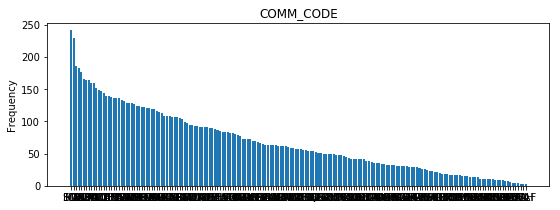

COMM_CODE
SIG    241
EDG    229
MRT    186
COV    183
VAR    177
      ... 
MEA      5
MAN      4
BEL      3
SGH      3
MAF      3
Name: COMM_CODE, Length: 181, dtype: int64


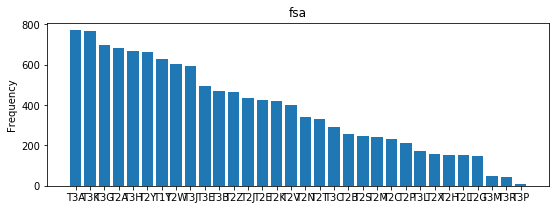

fsa
T3A    770
T3K    766
T3G    699
T2A    685
T3H    666
T2Y    663
T1Y    630
T2W    604
T3J    596
T3E    493
T3B    471
T2Z    465
T2J    433
T2E    424
T2K    418
T2V    403
T2N    343
T2T    330
T3C    293
T2B    258
T2S    249
T2M    243
T2C    230
T2P    213
T3L    174
T2X    160
T2H    155
T2L    152
T2G    148
T3M     51
T3R     45
T3P      9
Name: fsa, dtype: int64


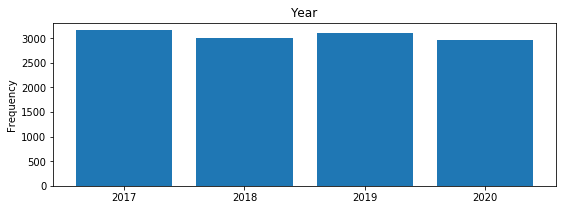

Year
2017    3157
2019    3114
2018    2996
2020    2972
Name: Year, dtype: int64


In [33]:
for i in ['COMM_CODE','fsa','Year']:
    bar_plot(i)
    

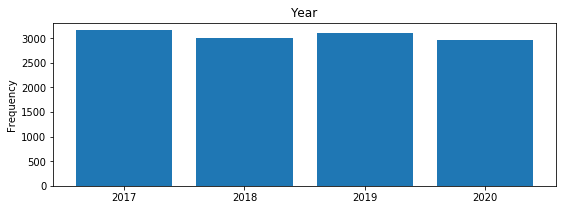

Year
2017    3157
2019    3114
2018    2996
2020    2972
Name: Year, dtype: int64


['ADDRESS',
 'COMM_CODE',
 'COMM_NAME',
 'location',
 'fsa',
 'LATITUDE',
 'LONGITUDE',
 'ROLL_NUMBER',
 'Year']

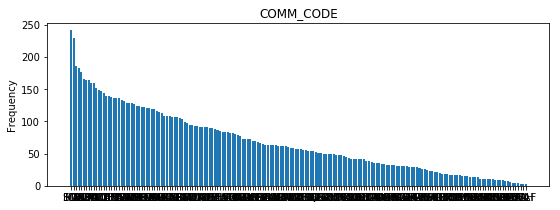

COMM_CODE
SIG    241
EDG    229
MRT    186
COV    183
VAR    177
      ... 
MEA      5
MAN      4
BEL      3
SGH      3
MAF      3
Name: COMM_CODE, Length: 181, dtype: int64


In [45]:
categorical=['COMM_CODE','fsa','Year']

for i in range(0,3):
    print(train[[categorical[i], "pct_change"]].groupby([categorical[i]], as_index=False).mean().sort_values(by="pct_change", ascending=False))

    COMM_CODE  pct_change
8         BEL    0.294895
143       SGH    0.107538
17        BRT    0.081839
117       PKD    0.031295
123       RAM    0.018946
..        ...         ...
46        DNC   -0.044312
18        BYV   -0.047523
48        DNW   -0.048098
9         BLN   -0.049562
127       RED   -0.061407

[181 rows x 2 columns]
    fsa  pct_change
29  T3M   -0.000282
7   T2J   -0.000683
9   T2L   -0.005364
11  T2N   -0.006136
10  T2M   -0.006666
31  T3R   -0.006896
5   T2G   -0.010321
26  T3J   -0.012388
3   T2C   -0.013896
2   T2B   -0.014576
14  T2T   -0.014827
20  T3A   -0.014837
24  T3G   -0.015860
4   T2E   -0.016862
8   T2K   -0.017514
19  T2Z   -0.018037
23  T3E   -0.018214
6   T2H   -0.018377
21  T3B   -0.018850
0   T1Y   -0.019154
1   T2A   -0.019960
15  T2V   -0.020219
27  T3K   -0.020261
25  T3H   -0.020337
16  T2W   -0.022549
18  T2Y   -0.022865
13  T2S   -0.026386
22  T3C   -0.026435
17  T2X   -0.027286
28  T3L   -0.035980
12  T2P   -0.037240
30  T3P   -0.041683
   Y

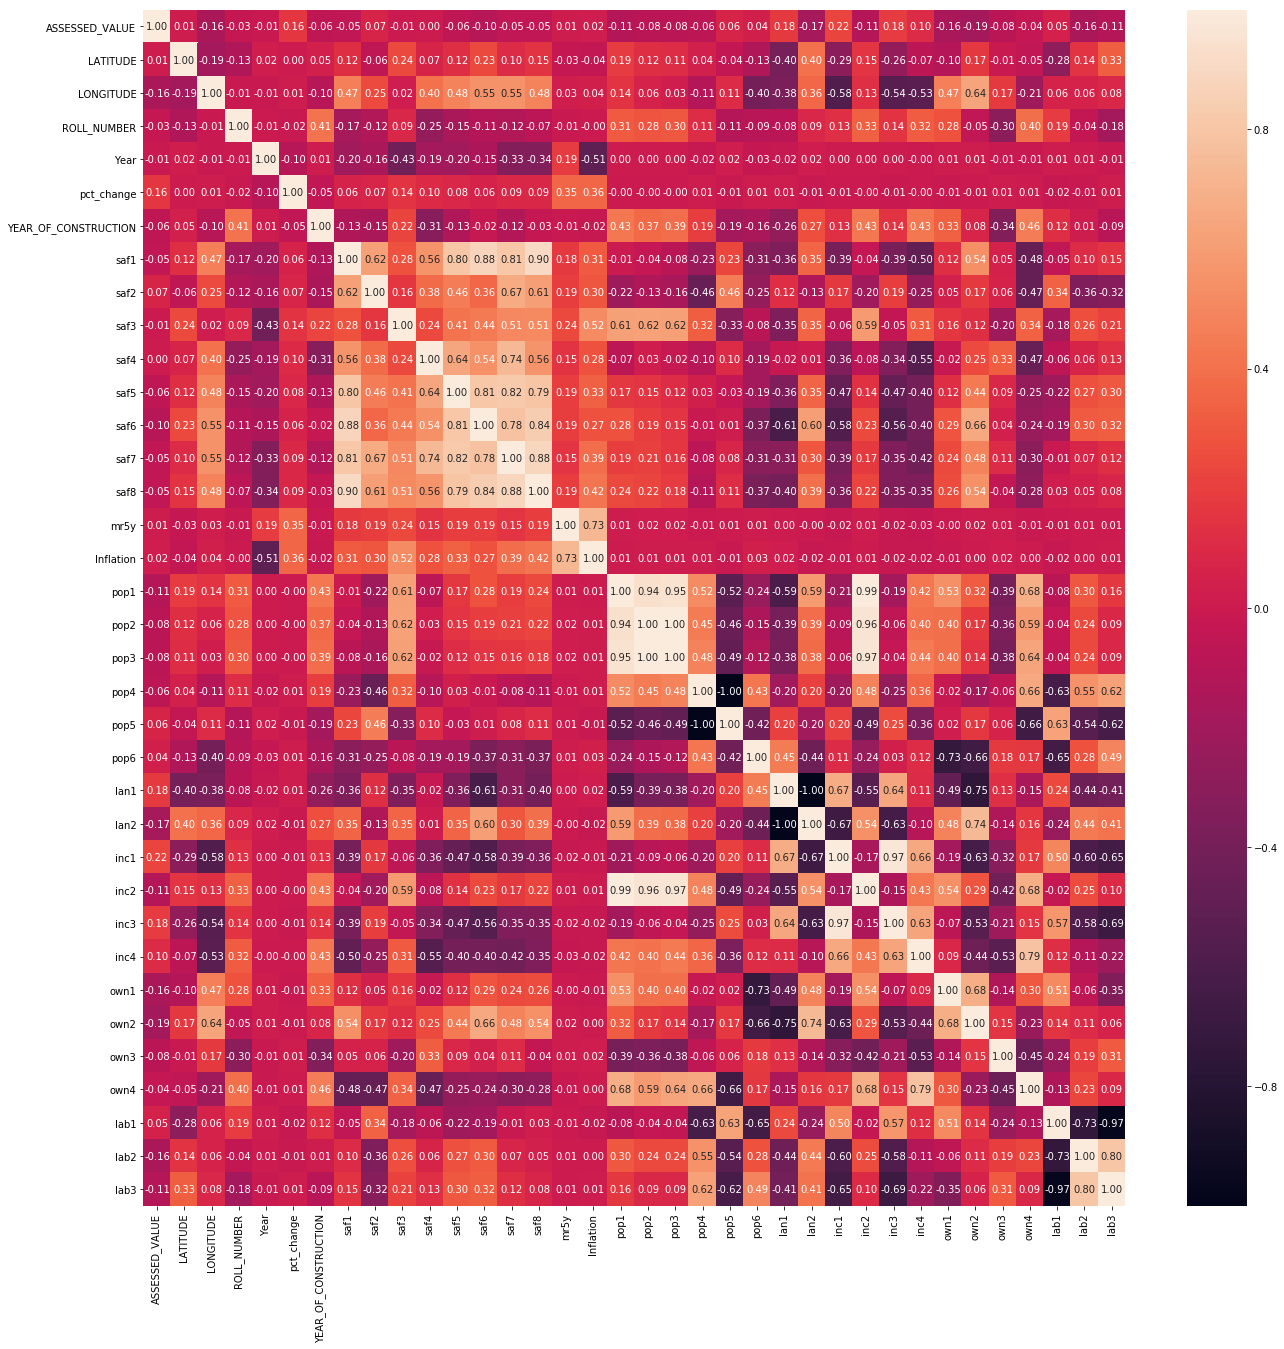

In [59]:
#train.corr()
f,ax=plt.subplots(figsize=(22,22))
sns.heatmap(train.corr(), vmax=1, vmin=-1, annot=True, fmt=".2f")
plt.show()

(-0.293, 0.0607]    11566
(0.0607, 0.414]       652
(0.414, 0.768]         10
(0.768, 1.121]          4
(-0.646, -0.293]        4
(2.182, 2.536]          1
(1.121, 1.475]          1
(-1.004, -0.646]        1
(1.829, 2.182]          0
(1.475, 1.829]          0
Name: pct_change, dtype: int64